---
layout: page
title: Gradiente Descendente
nav_order: 17
---

[<img src="./colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/icd-ufmg/icd-ufmg.github.io/blob/master/_lessons/17-gradiente.ipynb)

# Gradiente Descendente

{: .no_toc .mb-2 }

Entendimento de relação entre dados.
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Entender como o computador otimiza funções
1. Entender o algoritmo de gradiente descendente e ascendente
1. Implementar os dois

---
**Sumário**
1. TOC
{:toc}
---

In [1]:
# -*- coding: utf8

from scipy import stats as ss

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [3]:
plt.ion()

In [4]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

# Aula 18 - Gradiente Descendente (*Gradient Descent*)


**Material adaptado do Professor Pedro Olmo**

Ao fazer ciência de dados é comum se deparar com casos onde buscamos um melhor modelo. Diferente dos testes de hipóteses, onde buscamos a chance dos nossos dados em um modelo. Aqui, estamos tentando encontrar o melhor modelo para uma determinada situação. Geralmente "melhor" significará algo como "minimiza o erro do modelo" ou "maximiza a verossimilhaça dos dados". 

Para casos simples, como na regressão linear, é possível achar o melhor modelo usando cálculo. Porém, em casos particulares, precisamos achar tal modelo na marra. Nossa abordagem será uma técnica chamada gradiente descendente, que funciona muito bem para diferentes cenário. Gradiente descendente é a base da maioria dos __frameworks__ de aprendizado de máquina. Você pode não achar isso super excitante por si só, mas ao combinar gradiente descendente com modelos complexos temos a fórmula do sucesso de aprendizando hoje em dia.

## A ideia por trás do gradiente descendente

Vamos focar no caso de regressão linear com dados z-normalizados. Aqui, temos um modelo muito simples:

$$y_i = \beta x_i + \epsilon_i$$

Sabemos tratar com o mesmo de um ponto de vista de minimos quadrados como também de máxima verossimilhança. Vamos explorar uma base onde queremos prever o comprimento dos narizes de Kangaroos. Para isto vamos usar uma feature fantástica, a largura do nariz do Kangaroo.

In [5]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/18-GradienteDescendente/gray-kangaroos.csv', names=['comprimento', 'largura'], header=0)
df.head()

,comprimento,largura
0,609,241
1,629,222
2,620,233
3,564,207
4,645,247


Abaixo temos o modelo.

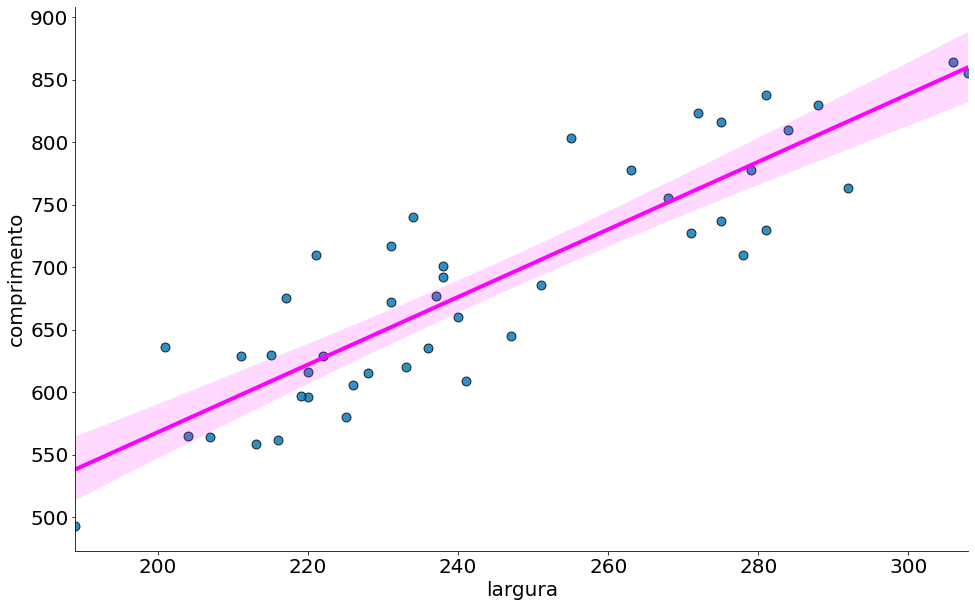

In [6]:
sns.regplot(x='largura', y='comprimento', data=df, n_boot=10000,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
despine()

z-normalizando

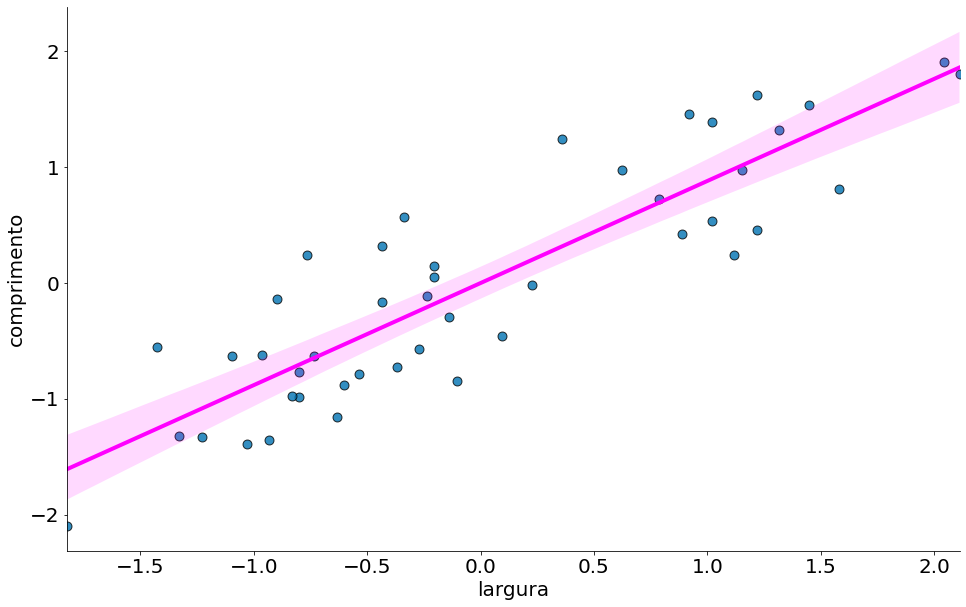

In [7]:
df -= df.mean()
df /= df.std(ddof=1)
sns.regplot(x='largura', y='comprimento', data=df, n_boot=10000,
            line_kws={'color':'magenta', 'lw':4},
            scatter_kws={'edgecolor':'k', 's':80, 'alpha':0.8})
despine()

A regressão. Note o intercepto = 0.

In [8]:
y = df['comprimento']
x = df['largura']
ss.linregress(x, y)

LinregressResult(slope=0.8814144365382701, intercept=5.560934949938166e-16, rvalue=0.8814144365382703, pvalue=1.3423645343535288e-15, stderr=0.07203174220550969)

Abaixo temos um plot com a soma dos erros ao quadrado que é utilizado para chegar na reta. Lembre-se das aulas anteriores. Chegamos no resultado acima usando cálculo, isto é, setamos as derivadas para zero. Uma outra abordagem para minimizar o erro é escolher um ponto de partida aleatório. Deste, calculamos o gradiente (derivadas). Depois, damos um pequeno passo na oposta do gradiente.

Inicialmente, observe como o erro é para um ponto. Lembrando que estamos trabalhando com uma função de erros quadrado. Diferente das aulas anteriores, ao invés de somar a mesma vamos tirar a média. Como o número de pontos, $n$, é uma constante, não afeta nossos algoritmos. Ao setar a derivada para zero o n some. De qualquer forma, pode ajudar os nossos algoritmos (evitar overflow).

$L(\beta) = n^{-1} \sum_i (y_i - \beta x_i)^2$

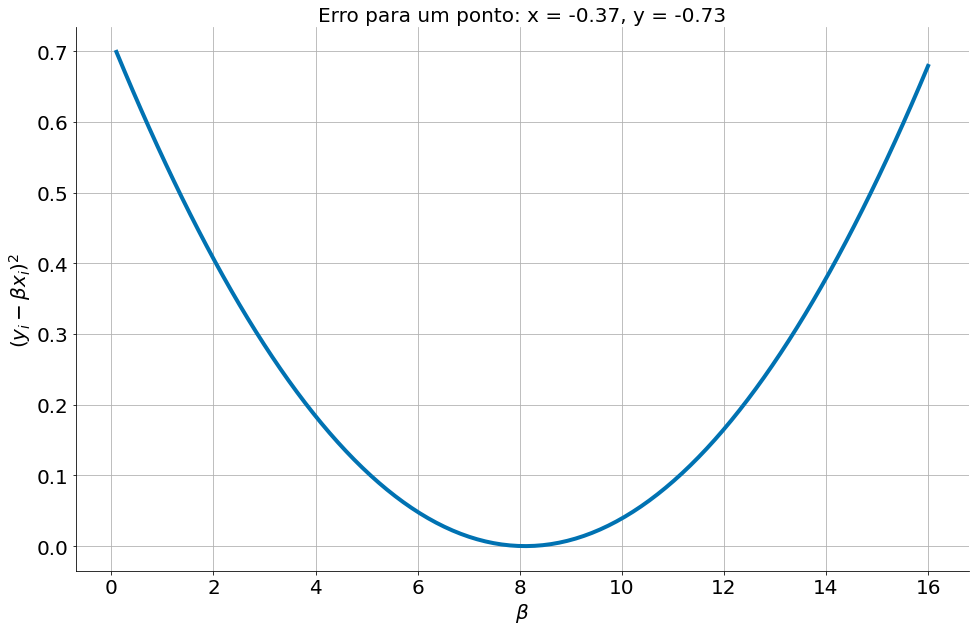

In [9]:
betas = np.linspace(0.1, 16, 100)
errs = np.zeros_like(betas)
for j in range(len(betas)):
    err = ((y[0] - betas[j] * x[0]) ** 2).mean()
    errs[j] = err
plt.plot(betas, errs, label='L(beta)')
plt.xlabel(r'$\beta$')
plt.title(r'Erro para um ponto: x = {:.2f}, y = {:.2f}'.format(x[2], y[2]))
plt.ylabel(r'$(y_i - \beta x_i)^2$')
plt.grid()
despine()

A soma de duas funções convexas é convexa. Então, a soma do erro quadrado nos pontos tamém é convexa. (prova nos slides)

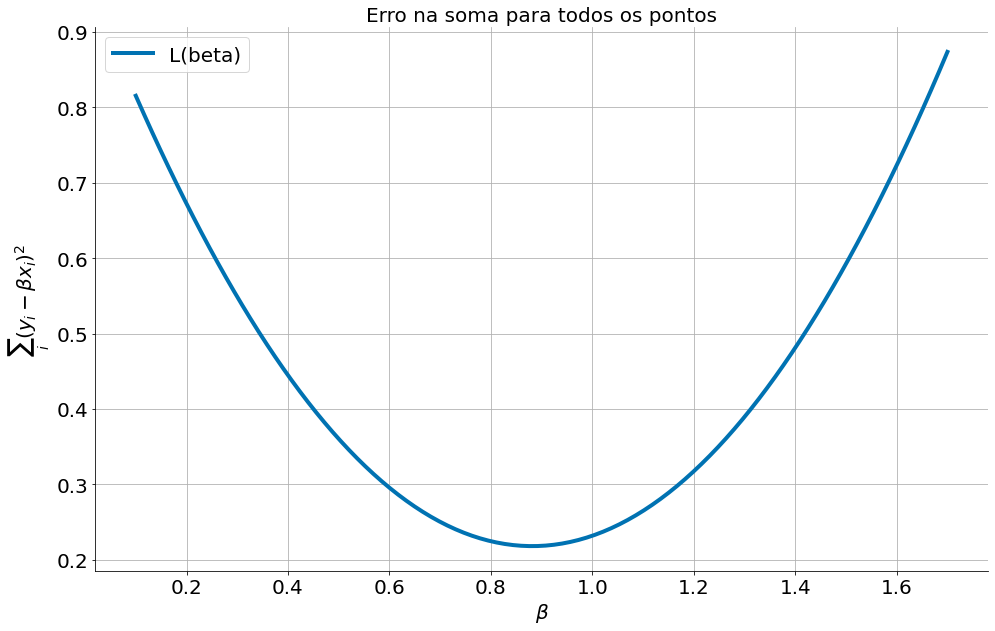

In [10]:
betas = np.linspace(0.1, 1.7, 100)
errs = np.zeros_like(betas)
grads = np.zeros_like(betas)
for j in range(len(betas)):
    err = ((y - betas[j] * x) ** 2).mean()
    grads[j] = (-2 * (y - betas[j] * x) * x).mean()
    errs[j] = err
plt.plot(betas, errs, label='L(beta)')
#plt.plot(betas, grads, label='L\'(beta)')
plt.xlabel(r'$\beta$')
plt.title(r'Erro na soma para todos os pontos')
plt.ylabel(r'$\sum_i(y_i - \beta x_i)^2$')
plt.legend()
plt.grid()
despine()

Observe que essa função possui um ponto de mínimo nas quando $\beta \approx 0.9$.  Observe que o gradiente, ou a derivada, é negativa quando estamos do lado esquero do mínimo. É positiva do lado direto e zero no valor ótimo. Então, a partir de um local inicial o sinal da derivada, na verdade o oposto do sinal como estamos minimizando, indica a direção que devemos ir.

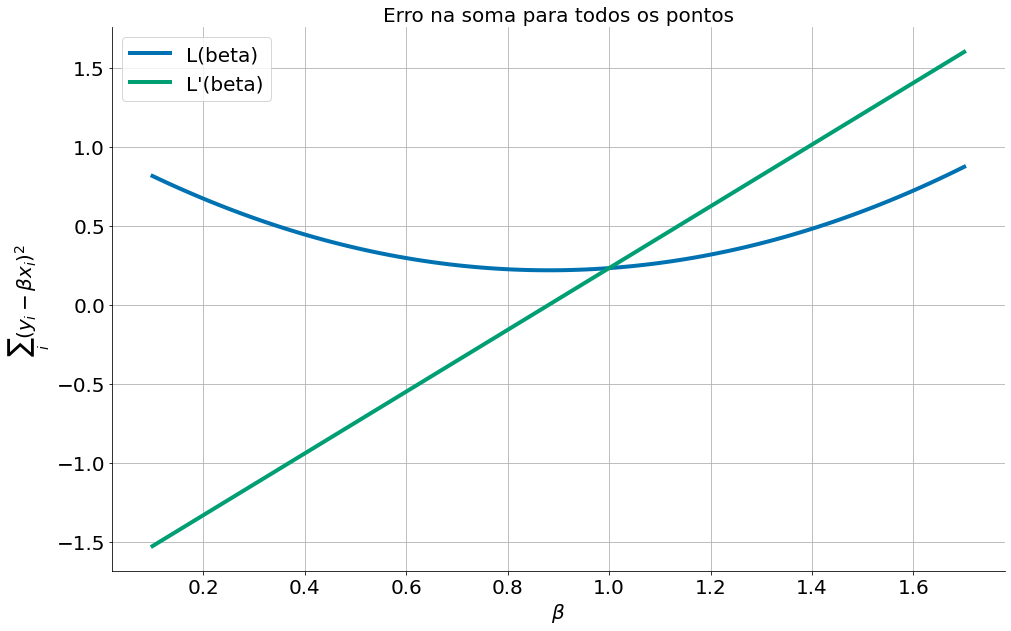

In [11]:
plt.plot(betas, errs, label='L(beta)')
plt.plot(betas, grads, label='L\'(beta)')
plt.xlabel(r'$\beta$')
plt.title(r'Erro na soma para todos os pontos')
plt.ylabel(r'$\sum_i(y_i - \beta x_i)^2$')
plt.legend()
plt.grid()
despine()

Caso você tenha problemas com derivadas, use o módulo sympy. Abaixo temos a derivadas para um ponto apenas.

In [12]:
import sympy as sy

x_i , y_i, beta = sy.symbols('x_i y_i beta')
fun = (y_i - beta * x_i)**2
sy.diff(fun, beta)

-2*x_i*(-beta*x_i + y_i)

## Gradiente Descendente

Com o conhecimento acima temos a base do Gradiente Descendente. Iniciando de um local qualquer, $\beta=2$. Vamos:

1. Computar a derivada $\frac{dL(\beta)}{d\beta}$
1. Setar $\beta = \beta - \lambda \frac{dL(\beta)}{d\beta}$
1. Repetir

O valor de $\lambda$ define nossa taxa de aprendizado. 

In [13]:
def ssq_znormed(x, y, beta):
    return ((y - beta * x) ** 2).mean()

In [14]:
def grad_znormed(x, y, beta):
    return (-2 * x * (y - beta * x)).mean()

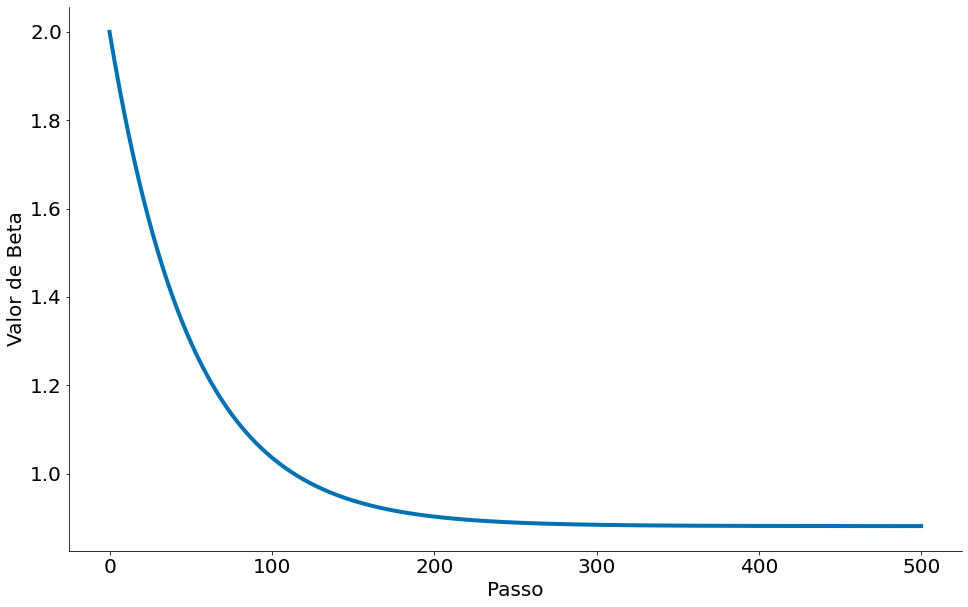

In [15]:
beta = 2
beta_passo = [beta]
erros = []
for _ in range(500):
    err_sq = ssq_znormed(x, y, beta)
    grad = grad_znormed(x, y, beta)
    beta = beta - 0.01 * grad
    beta_passo.append(beta)
    erros.append(err_sq)
plt.plot(beta_passo)
plt.xlabel('Passo')
plt.ylabel('Valor de Beta')
despine()

Observe os erros

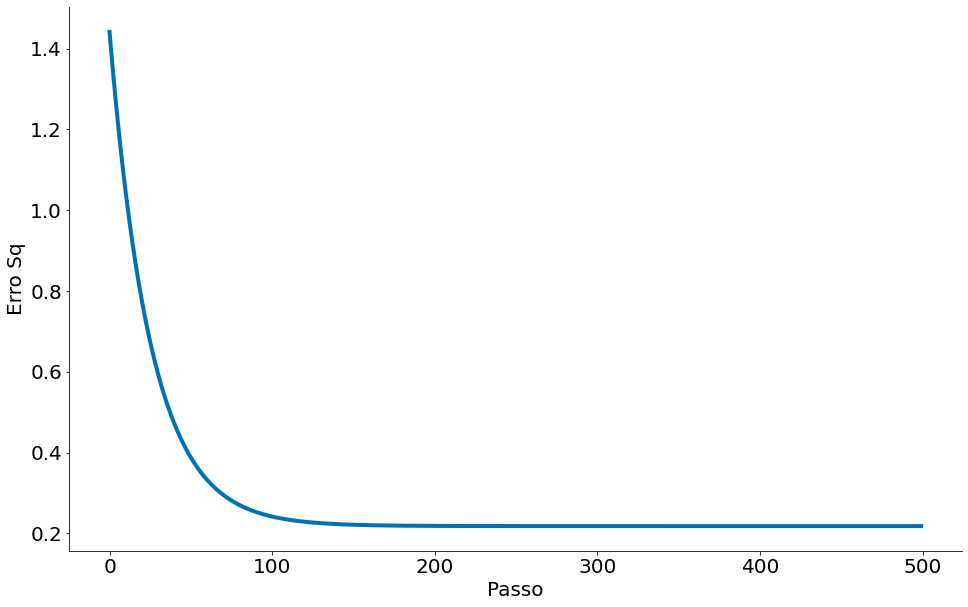

In [16]:
plt.plot(erros)
plt.xlabel('Passo')
plt.ylabel('Erro Sq')
despine()

## Gradiente Descendente Estocástico

Muitas vezes usaremos o gradiente descendente para escolher os parâmetros de um modelo de maneira a minimizar alguma noção de erro. Usando a abordagem em lote anterior, cada etapa do método exige que façamos uma previsão e calculemos o gradiente para todo o conjunto de dados, o que faz com que cada etapa demore muito.

Geralmente, essas funções de erro são *aditivas*, o que significa que o erro preditivo em todo o conjunto de dados é simplesmente a soma dos erros preditivos para cada ponto de dados.

Quando este é o caso, podemos, em vez disso, aplicar uma técnica chamada gradiente descendente estocástico (ou *stochastic gradient descent*), que calcula o gradiente (e dá um passo) para apenas um ponto por vez. Ele passa sobre os dados repetidamente até atingir um ponto de parada.

Durante cada ciclo, queremos iterar nossos dados em uma ordem aleatória:

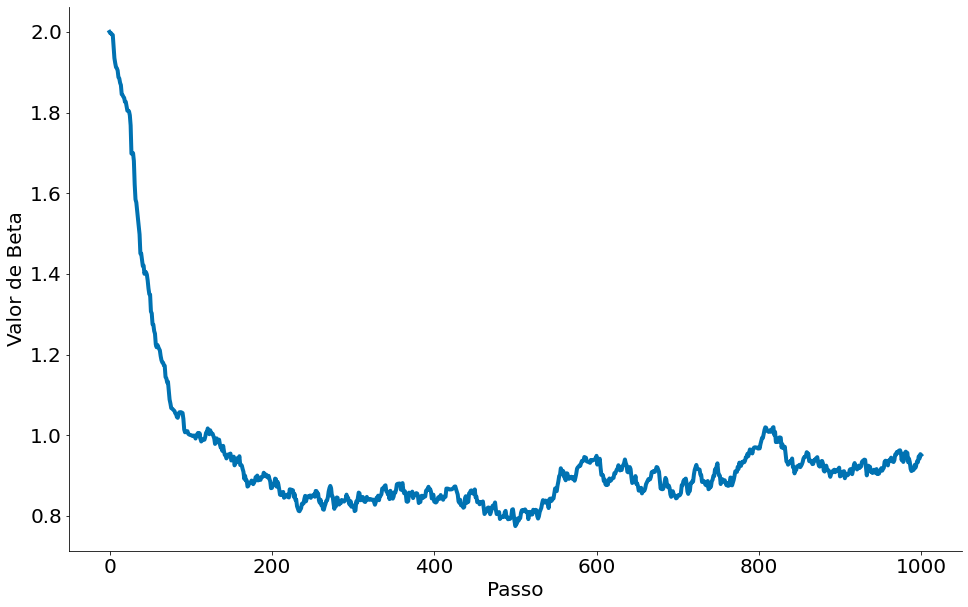

In [17]:
beta = 2
beta_passo = [beta]
erros = []
for _ in range(1000):
    i = np.random.randint(0, len(x))
    x_i, y_i = x[i], y[i]
    err_sq = ssq_znormed(x, y, beta) # esta linha ainda precisa ser em todos os pontos
    grad = grad_znormed(x_i, y_i, beta)
    beta = beta - 0.01 * grad
    beta_passo.append(beta)
    erros.append(err_sq)
plt.plot(beta_passo)
plt.xlabel('Passo')
plt.ylabel('Valor de Beta')
despine()

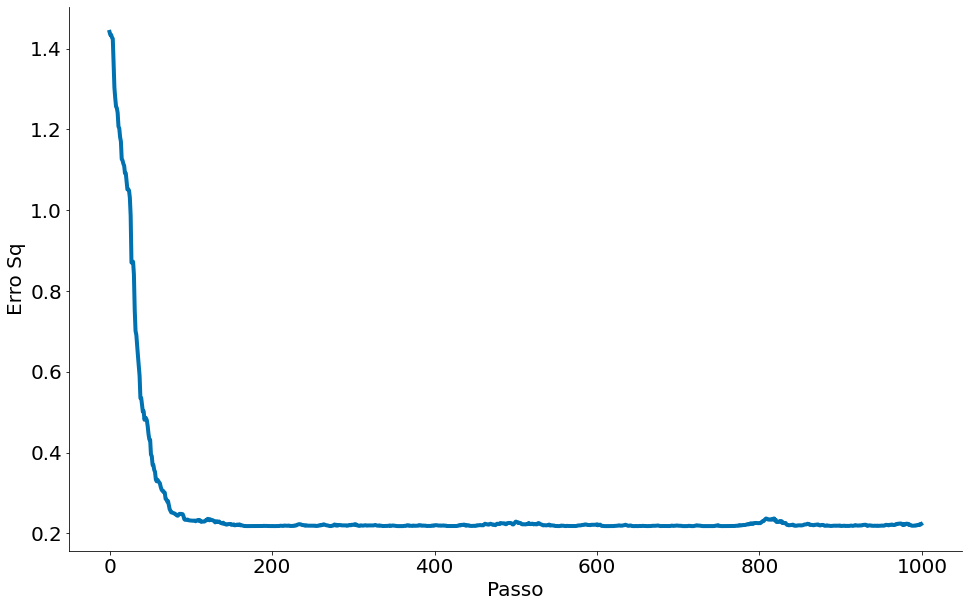

In [18]:
plt.plot(erros)
plt.xlabel('Passo')
plt.ylabel('Erro Sq')
despine()

## Escolhendo o tamanho certo do passo

Embora o raciocínio para se mover na direção oposta ao gradiente seja claro, até que ponto mover-se não é. De fato, escolher o tamanho certo do passo que devemos nos mover é mais uma arte do que uma ciência. Opções populares incluem:

* Usar um tamanho de passo fixo;

* Diminuir gradualmente o tamanho do passo ao longo do tempo;

* Em cada etapa, escolha o tamanho do passo que minimiza o valor da função objetivo.

O último parece ótimo, mas é, na prática, um cálculo caro. Podemos aproximá-lo tentando uma variedade de tamanhos de passo e escolhendo aquele que resulta no menor valor da função objetivo:

## Caso Multivariado

Até agora estamos roubando um pouco ao normalizar os dados. Isto é, estamos forçando $\alpha=0$ na equação abaixo:

$$y_i = \beta x_i + \alpha$$

Vamos voltar para os dados originais. Note que o resultado da regressão é outro. Em particular, o intercepto é 22. Queremos estimar o mesmo também.

In [19]:
x = np.random.normal(size=1000)
y = 2 * x + np.random.normal(loc=3, size=1000)
ss.linregress(x, y)

LinregressResult(slope=1.9416732636887266, intercept=3.033966007834007, rvalue=0.8897448608393281, pvalue=0.0, stderr=0.031531628347458034)

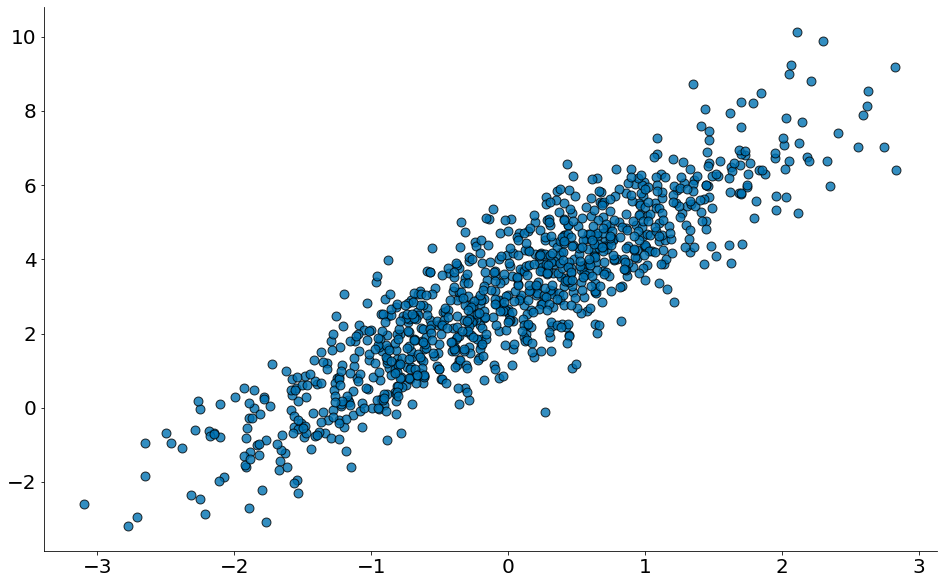

In [20]:
plt.scatter(x, y, alpha=0.8, s=80, edgecolors='k')
despine()

Abaixo tenho as derivadas:

$$\frac{dL}{d\alpha} = n^{-1}\sum_i 2 (-y_i + \beta x_i + \alpha)$$

$$\frac{d L}{d\beta} =n^{-1} \sum_i 2 (-y_i + \beta x_i + \alpha) x_i$$

In [21]:
def derivadas_regressao(parametros, x, y):
    alpha, beta = parametros
    da = (-2 * y) + (2 * beta * x) + (2 * alpha)
    db = (-2 * y * x) + (2 * beta * (x ** 2)) + (2 * alpha * x)
    return np.array([da.mean(), db.mean()])

Um gradient descent simples. O mesmo vai parar de executar quando os parâmetros convergem. Aqui temos uma função mais organizada. A mesma recebe uma outra função de derivada.

In [22]:
def gd(parametros, d_fun, x, y, lambda_=0.01):
    parametros = parametros.copy()
    for i in range(1000):
        grad = d_fun(parametros, x, y)
        parametros_novos = parametros - lambda_ * grad
        if np.abs(parametros - parametros_novos).mean() <= 0.00001:
            break
        parametros = parametros_novos
        print('Iter {}; alpha, beta = '.format(i), parametros)
    return parametros

Resposta!

In [23]:
parametros_iniciais = np.array([1, 1])
gd(parametros_iniciais, derivadas_regressao, x, y)

Iter 0; alpha, beta =  [1.04079108 1.01956402]
Iter 1; alpha, beta =  [1.08076401 1.03872175]
Iter 2; alpha, beta =  [1.11993521 1.05748163]
Iter 3; alpha, beta =  [1.15832076 1.07585192]
Iter 4; alpha, beta =  [1.19593642 1.09384071]
Iter 5; alpha, beta =  [1.23279763 1.11145591]
Iter 6; alpha, beta =  [1.26891952 1.12870528]
Iter 7; alpha, beta =  [1.30431693 1.14559642]
Iter 8; alpha, beta =  [1.33900439 1.16213676]
Iter 9; alpha, beta =  [1.37299614 1.17833358]
Iter 10; alpha, beta =  [1.40630612 1.19419402]
Iter 11; alpha, beta =  [1.43894803 1.20972506]
Iter 12; alpha, beta =  [1.47093526 1.22493354]
Iter 13; alpha, beta =  [1.50228093 1.23982615]
Iter 14; alpha, beta =  [1.53299793 1.25440945]
Iter 15; alpha, beta =  [1.56309885 1.26868987]
Iter 16; alpha, beta =  [1.59259606 1.28267368]
Iter 17; alpha, beta =  [1.62150167 1.29636706]
Iter 18; alpha, beta =  [1.64982754 1.30977602]
Iter 19; alpha, beta =  [1.6775853  1.32290648]
Iter 20; alpha, beta =  [1.70478635 1.33576422]
It

array([3.03324037, 1.94142651])

Observe como alpha é o intercept e beta o slope da regressão com scipy

In [24]:
ss.linregress(x, y)

LinregressResult(slope=1.9416732636887266, intercept=3.033966007834007, rvalue=0.8897448608393281, pvalue=0.0, stderr=0.031531628347458034)

## Gradiente Ascendente

Vamos agora chegar no mesmo resultado usando Gradiente Ascendente. Em particular, ainda vamos nos manter em uma regressão linear. Porém, queremos maximizar a log-verossimilhança. Da aula anterior, nosso modelo é:

$$y_i = \beta x_i + \alpha + \epsilon_i $$
$$\epsilon_i = y_i - \beta x_i - \alpha $$
$$\epsilon_i \sim Normal(0, \sigma) $$

Partindo do mesmo chegamos em:

$$p(\epsilon_i\mid \sigma^2, \alpha, \beta) = \frac{1}{\sqrt {\sigma ^22\pi } }
e^{- ({y_i - \beta x_i - \alpha })^2 / 2\sigma^2} $$


Assumindo que cada erro é independente, a verossimilhança de todos os erros é:

$$p_{\Theta}(E) = \prod_{i} p_{\Theta}(\epsilon_i) \\
\log(p_{\Theta}(E)) = \mathcal{l}_{\Theta}(E) =  \sum_{i} \log(p_{\Theta}(\epsilon_i))$$

O log da mesma é:

$$\mathcal{l}_{\Theta}(E) =  -n \log(\sqrt{2\pi}) - n{\log(\sigma) } - { \sum^n_{i=1} ({y_i - \beta x_i - \alpha })^2 \over 2\sigma^2} $$

A derivada em $\sigma$ é:

$${d \mathcal{l}_{\Theta} \over d\sigma} =  -{n\over \sigma} + { 2 \sum^n_{i=1} ({y_i - \beta x_i - \alpha })^2 \over 2\sigma^3}$$

A derivada em $\alpha$ e $\beta$ é a mesma de antes, apenas invertemos o sinal:

$$\frac{d\mathcal{l}_{\Theta}}{d\alpha} = -n^{-1} \sum_i 2 (-y_i + \beta x_i + \alpha)$$

$$\frac{d\mathcal{l}_{\Theta}}{d\beta} = -n^{-1} \sum_i 2 (-y_i + \beta x_i + \alpha) x_i$$

Em outras palavras, vamos chegar no mesmo resultado.

In [25]:
def derivadas_vero(parametros, x, y):
    alpha, beta = parametros
    da = -1 * ((-2 * y) + (2 * beta * x) + (2 * alpha))
    db = -1 * ((-2 * y * x) + (2 * beta * (x ** 2)) + (2 * alpha * x))
    return np.array([da.mean(), db.mean()])

In [26]:
def ga(parametros, d_fun, x, y, lambda_=0.01):
    parametros = parametros.copy()
    print('Iter {}; alpha, beta = '.format(-1), parametros)
    for i in range(1000):
        grad = d_fun(parametros, x, y)
        parametros_novos = parametros + lambda_ * grad
        if np.abs(parametros - parametros_novos).mean() <= 0.00001:
            break
        parametros = parametros_novos
        print('Iter {}; alpha, beta = '.format(i), parametros)
    return parametros

In [27]:
parametros_iniciais = np.array([0.1, 0.1])
parametros = ga(parametros_iniciais, derivadas_vero, x, y)

Iter -1; alpha, beta =  [0.1 0.1]
Iter 0; alpha, beta =  [0.15889788 0.13813834]
Iter 1; alpha, beta =  [0.21661329 0.17548712]
Iter 2; alpha, beta =  [0.27316995 0.21206267]
Iter 3; alpha, beta =  [0.32859113 0.24788099]
Iter 4; alpha, beta =  [0.38289965 0.28295777]
Iter 5; alpha, beta =  [0.43611782 0.31730834]
Iter 6; alpha, beta =  [0.48826756 0.35094774]
Iter 7; alpha, beta =  [0.53937032 0.38389069]
Iter 8; alpha, beta =  [0.5894471  0.41615161]
Iter 9; alpha, beta =  [0.63851853 0.4477446 ]
Iter 10; alpha, beta =  [0.68660477 0.4786835 ]
Iter 11; alpha, beta =  [0.73372562 0.50898185]
Iter 12; alpha, beta =  [0.77990046 0.53865289]
Iter 13; alpha, beta =  [0.82514827 0.56770962]
Iter 14; alpha, beta =  [0.86948769 0.59616476]
Iter 15; alpha, beta =  [0.91293693 0.62403074]
Iter 16; alpha, beta =  [0.95551389 0.65131978]
Iter 17; alpha, beta =  [0.99723607 0.67804381]
Iter 18; alpha, beta =  [1.03812063 0.70421452]
Iter 19; alpha, beta =  [1.0781844  0.72984337]
Iter 20; alpha, 

In [28]:
ss.linregress(x, y)

LinregressResult(slope=1.9416732636887266, intercept=3.033966007834007, rvalue=0.8897448608393281, pvalue=0.0, stderr=0.031531628347458034)

## MLE

Abaixo tenho os plots para MLE. O material está nos slides.

In [29]:
x = np.array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0])
x

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0])

In [30]:
thetas = np.linspace(0.01, 0.99, 1000)

In [31]:
l = []
for theta in thetas:
    model = (theta ** x) * ((1 - theta) ** (1-x))
    l.append(model.prod())

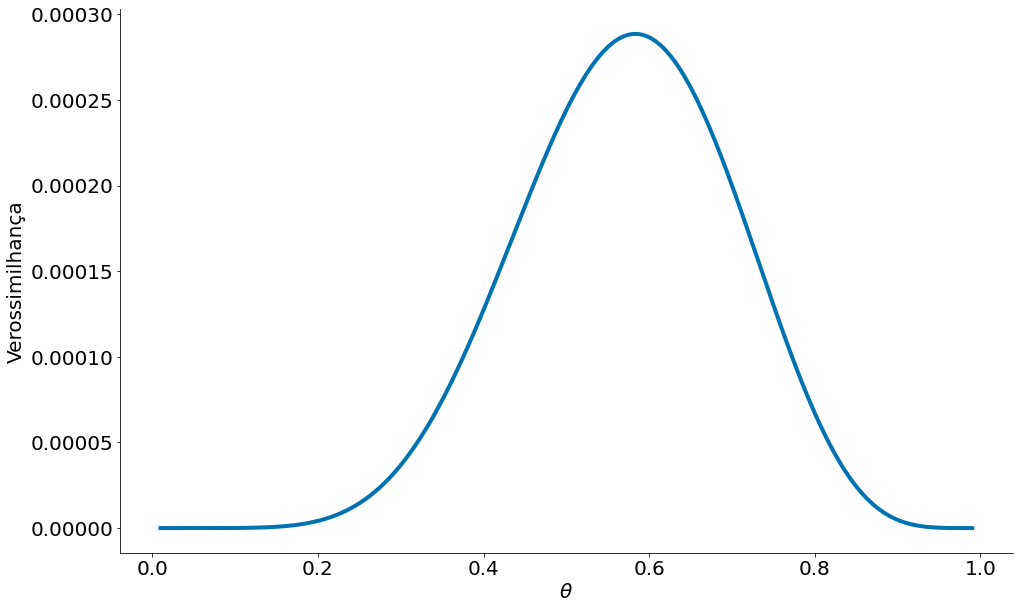

In [32]:
plt.plot(thetas, l)
plt.xlabel(r'$\theta$')
plt.ylabel('Verossimilhança')
despine()

In [33]:
ll = []
for theta in thetas:
    model = np.log((theta ** x) * ((1 - theta) ** (1-x)))
    ll.append(model.sum())

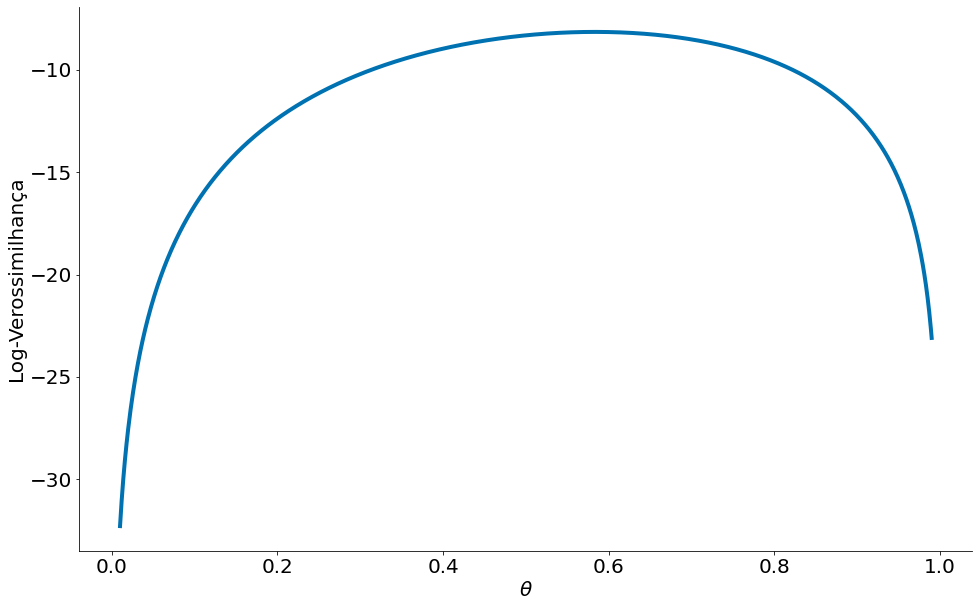

In [34]:
plt.plot(thetas, ll)
plt.xlabel(r'$\theta$')
plt.ylabel('Log-Verossimilhança')
despine()